# Домашнее задание №1 - Применение методов NLP


В этом домашнем задании мы будем работать с данными из сорневнования: 
[Toxic comment classification challenge](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge)
  
  
В задании небходимо по тексту комментария определить веротяности следующих категорий:
- toxic
- severe_toxic
- obscene
- threat
- insult
- identity_hate

Как и в соревновании мы везде будем использовать метрику ROC AUC для валидации

_Обратите внимание, что каждый комментарий может иметь несколько меток разных классов_

### Что нужно сделать? 

1. Подготовка __[10%]__:
    - Скачайте данные, проведите первоначальные EDA: баланс классов, пересечение классов и т.д. 
    

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\r\nWhy the edits made under my use...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\r\nMore\r\nI can't make any real suggestions...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
print("Check for missing values in Train dataset")
null_check=train.isnull().sum()
print(null_check)

Check for missing values in Train dataset
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64


In [5]:
count_classes = train.iloc[:,2:].sum(axis = 1)
train['clean'] = (count_classes == 0)
print("Total comments = ", len(train))
print("Total clean comments = ", train['clean'].sum())
print("Total tags = ", count_classes.sum())

Total comments =  159571
Total clean comments =  143346
Total tags =  35098


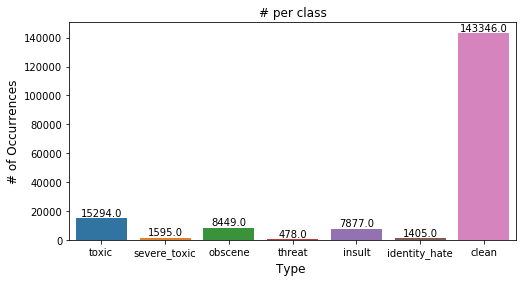

In [6]:
import seaborn as sns

classes=train.iloc[:,2:].sum()
plt.figure(figsize=(8,4))
ax= sns.barplot(classes.index, classes.values)
plt.title("# per class")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Type ', fontsize=12)
rects = ax.patches
labels = classes.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

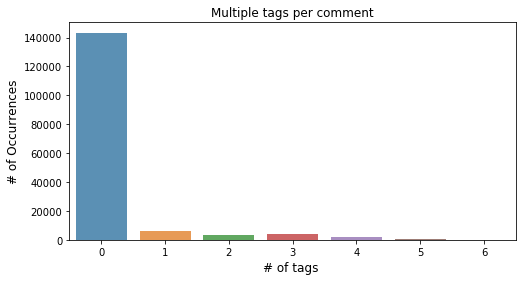

0    143346
1      6360
3      4209
2      3480
4      1760
5       385
6        31
dtype: int64


In [7]:
x=count_classes.value_counts()

plt.figure(figsize=(8,4))
ax = sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Multiple tags per comment")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of tags ', fontsize=12)
plt.show()
print(x)

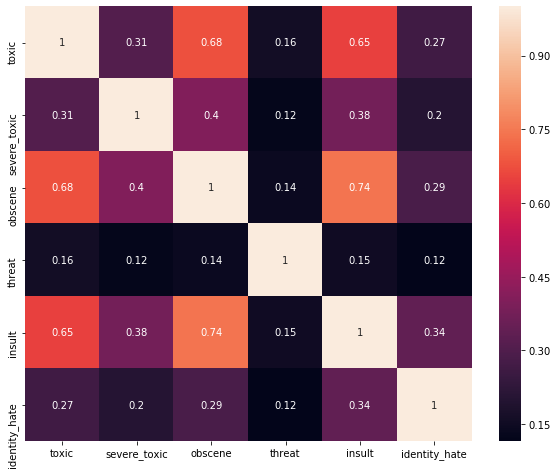

In [8]:
temp_df=train.iloc[:,2:-1]

corr=temp_df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True);

In [9]:
main_col="toxic"
corr_mats=[]
for other_col in temp_df.columns[1:]:
    confusion_matrix = pd.crosstab(temp_df[main_col], temp_df[other_col])
    array_conf_matrix = np.array(confusion_matrix.values)
    df_conf_matrix = pd.DataFrame(array_conf_matrix)
    corr_mats.append(df_conf_matrix)
out = pd.concat(corr_mats,axis=1,keys=temp_df.columns[1:])
out.index.name = 'toxic'

out

severe_toxic       obscene        threat       insult        \
                 0     1       0     1       0    1       0     1   
toxic                                                               
0           144277     0  143754   523  144248   29  143744   533   
1            13699  1595    7368  7926   14845  449    7950  7344   

      identity_hate        
                  0     1  
toxic                      
0            144174   103  
1             13992  1302

## Все очень токсичные комментарии - токсичные

# Придумайте и обоснуйте стратегию валидации.
Сделайте предбработку данных. Оцените что требуется делать с символами, заглавными буквами. Проведите лемматизацию или стеминг.

# Сделал Adversarial validation, вроде неплохо сходится с тестом

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import re, string
import time
from scipy.sparse import hstack, vstack

from sklearn.model_selection import StratifiedKFold

In [11]:
def tokenize(s): 
#     global a
#     if a == 0:
#         print(s)
#         a = 1
    return re_tok.sub(r' \1 ', s).split()

In [12]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [13]:
tmp = "explanation why the edits made under my username hardcore metallica fan were reverted? they weren' t vandalisms, just closure on some gas after i voted at new york dolls fac. and please don't remove the template from the talk page since i'm retired now.89.205.38.27"

In [14]:
train['comment_text'][:5]

0    Explanation\r\nWhy the edits made under my use...
1    D'aww! He matches this background colour I'm s...
2    Hey man, I'm really not trying to edit war. It...
3    "\r\nMore\r\nI can't make any real suggestions...
4    You, sir, are my hero. Any chance you remember...
Name: comment_text, dtype: object

In [15]:
vec = TfidfVectorizer(ngram_range=(1,2), lowercase=True,
               min_df=4, strip_accents='unicode', use_idf=1,
                      smooth_idf=1, sublinear_tf=1)
tmp1 = vec.fit_transform(train['comment_text'][:1000])

In [16]:
# print(tmp1)

In [17]:
# print(vec.get_feature_names())

In [18]:
print('\1')




In [19]:
# Tf-idf

# prepare tokenizer
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')

# create sparse matrices
n = train.shape[0]
vec = TfidfVectorizer(ngram_range=(1,2), tokenizer=tokenize,
               min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1,
                      smooth_idf=1, sublinear_tf=1)
train_term_doc = vec.fit_transform(train['comment_text'])
test_term_doc = vec.transform(test['comment_text'])

In [20]:
# combine
ytrain = np.zeros((train_term_doc.shape[0]))
ytest = np.ones((test_term_doc.shape[0]))
# ydat = np.hstack((ytrain, ytest))

# xdat = vstack([train_term_doc, test_term_doc], format='csr') # разреженная матрица

In [21]:
nfolds = 10
seed = 42

# stratified split
skf = StratifiedKFold(n_splits=nfolds, random_state=seed, shuffle=True)

score_vec = np.zeros((train_term_doc.shape[0]))

In [22]:
for (f, (train_index, test_index)) in enumerate(skf.split(train_term_doc, ytrain)):
    print(test_index)
    score_vec[test_index] = test_index

[    20     24     34 ... 159557 159560 159561]
[     0      4     12 ... 159564 159568 159570]
[    23     31     39 ... 159494 159523 159542]
[    22     48     54 ... 159514 159551 159563]
[     3      8     14 ... 159549 159554 159555]
[     1      7     17 ... 159556 159558 159565]
[     6     21     29 ... 159518 159543 159567]
[     2      9     11 ... 159544 159550 159569]
[    10     16     18 ... 159538 159562 159566]
[     5     15     26 ... 159546 159548 159553]


In [23]:
score_vec

array([0.00000e+00, 1.00000e+00, 2.00000e+00, ..., 1.59568e+05,
       1.59569e+05, 1.59570e+05])

In [24]:
for (f, (train_index, test_index)) in enumerate(skf.split(train_term_doc, ytrain)):
    print(f)
    x_train = vstack([train_term_doc[train_index], test_term_doc], format='csr') # разреженная матрица
    y_train = np.hstack((ytrain[train_index], ytest))
#     print(x_train.shape, y_train.shape)
    
    x_pred = train_term_doc[test_index]
#     print(x_pred.shape)   

    clf = LogisticRegression()
    clf.fit(x_train, y_train)
    
    score_vec[test_index] = clf.predict_proba(x_pred)[:,1]
    

0


C:\Users\daniil\.conda\envs\keras-gpu\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1
2
3
4
5
6
7
8
9


In [25]:
score_vec

array([0.08667706, 0.01250078, 0.19284559, ..., 0.40649834, 0.13427026,
       0.26577031])

In [26]:
d = zip(score_vec, range(len(score_vec)))
d

In [27]:
d = list(d)

In [28]:
d.sort(reverse = True)
d

[(0.9999999888361576, 138308),
 (0.9999999870277558, 5899),
 (0.9999997587077896, 21006),
 (0.9999996949288759, 26302),
 (0.9999981539807209, 144777),
 (0.9999979601639992, 152734),
 (0.999997773018945, 102168),
 (0.9999963140987113, 139068),
 (0.999993787236596, 76077),
 (0.9999937096593495, 94613),
 (0.9999930949126881, 142050),
 (0.9999918670799578, 132921),
 (0.9999914606242452, 150297),
 (0.9999909606585367, 47867),
 (0.9999908419217896, 67626),
 (0.9999884698825029, 45228),
 (0.9999876205582292, 135859),
 (0.9999847010289344, 131779),
 (0.9999835180455837, 47806),
 (0.9999819878144973, 17429),
 (0.9999776512619029, 157945),
 (0.9999756180967504, 12681),
 (0.9999755243780958, 39344),
 (0.9999726446517953, 12537),
 (0.9999719399269217, 89507),
 (0.9999669726760142, 137634),
 (0.9999612038532105, 112575),
 (0.99996055059267, 97057),
 (0.9999588158870268, 86072),
 (0.9999567068063993, 124542),
 (0.9999542277008658, 76007),
 (0.9999537407039889, 25313),
 (0.9999490489066831, 82964),
 

In [29]:
_val_index = d[:len(d)//100*10]
_train_index = d[len(d)//100*10:]

In [30]:
_val_index = np.array(_val_index, dtype=int)[:,1]
_train_index = np.array(_train_index, dtype=int)[:,1]

In [32]:
_val_index

array([138308,   5899,  21006, ...,  48775,  93344, 115860])

In [42]:
train.iloc[0]

id                                                0000997932d777bf
comment_text     Explanation\r\nWhy the edits made under my use...
toxic                                                            0
severe_toxic                                                     0
obscene                                                          0
threat                                                           0
insult                                                           0
identity_hate                                                    0
clean                                                         True
Name: 0, dtype: object

In [43]:
_val = train.iloc[_val_index]
_train = train.iloc[_train_index]

In [44]:
_val.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean
138308,e40d368e676aab57,Bastered You Bastered==Bastered You Bastered==...,1,0,1,0,1,0,False
5899,0fc49fc47729784d,Copyright ===\r\n\r\n \r\n\r\n===,0,0,0,0,0,0,True
21006,3775bd2cf73139ec,==============\r\nQuestion: When was Mike Allr...,0,0,0,0,0,0,True
26302,45a16f6a72a97929,""":::::::::::It was in that area. \r\n""",0,0,0,0,0,0,True
144777,12354201bf69a812,""":::::::::::::::Prove it is false. \r\n""",0,0,0,0,0,0,True


In [45]:
_val.to_csv("_val.csv", index = None, header=True)
_train.to_csv("_train.csv", index = None, header=True)

In [46]:
_val = pd.read_csv("_val.csv")

In [47]:
_val.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean
0,e40d368e676aab57,Bastered You Bastered==Bastered You Bastered==...,1,0,1,0,1,0,False
1,0fc49fc47729784d,Copyright ===\r\n\r\n \r\n\r\n===,0,0,0,0,0,0,True
2,3775bd2cf73139ec,==============\r\nQuestion: When was Mike Allr...,0,0,0,0,0,0,True
3,45a16f6a72a97929,""":::::::::::It was in that area. \r\n""",0,0,0,0,0,0,True
4,12354201bf69a812,""":::::::::::::::Prove it is false. \r\n""",0,0,0,0,0,0,True


## лемматезация

In [48]:
from nltk import WordNetLemmatizer
from nltk import pos_tag, word_tokenize
def lemmatize_all(sentence):
    wnl = WordNetLemmatizer()
    for word, tag in pos_tag(word_tokenize(sentence)):
        if tag.startswith("NN"):
            yield wnl.lemmatize(word, pos='n')
        elif tag.startswith('VB'):
            yield wnl.lemmatize(word, pos='v')
        elif tag.startswith('JJ'):
            yield wnl.lemmatize(word, pos='a')
        elif tag.startswith('R'):
            yield wnl.lemmatize(word, pos='r')
            
        else:
            yield word

In [56]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\daniil\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\daniil\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.


True

In [51]:
import os
os.environ['OMP_NUM_THREADS'] = '10'

In [118]:
_train = pd.read_csv("_train.csv")
y_train = _train[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].values
_val = pd.read_csv("_val.csv")
y_val = _val[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].values
test = pd.read_csv("test.csv")

In [57]:
X_train1 = []
X_test1 = []
X_val1 = []
#Function call to lemmatize X_train and X_test
print ("Train data lemmatization begins")
for i in range(0,len(_train)):
    X_train1.append(" ".join(lemmatize_all(str(_train['comment_text'][i]))))
print ("Train data lemmatization ends")
print ("Val data lemmatization begins")
for i in range (0, len(_val)):
    X_val1.append(" ".join(lemmatize_all(str(_val['comment_text'][i]))))
print ("VAl data lemmatization ends")
print ("Test data lemmatization begins")
for i in range (0, len(test)):
    X_test1.append(" ".join(lemmatize_all(str(test['comment_text'][i]))))
print ("Test data lemmatization ends")

Train data lemmatization begins
Train data lemmatization ends
Val data lemmatization begins
VAl data lemmatization ends
Test data lemmatization begins
Test data lemmatization ends


In [3]:
from keras.preprocessing import text, sequence

Using TensorFlow backend.


In [121]:
max_features = 20000
maxlen = 100
embed_size = 50

tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train1) + list(X_val1) + list(X_test1))
X_train = tokenizer.texts_to_sequences(X_train1)
X_val = tokenizer.texts_to_sequences(X_val1)
X_test = tokenizer.texts_to_sequences(X_test1)
x_train = sequence.pad_sequences(X_train, maxlen=maxlen)
x_val = sequence.pad_sequences(X_val, maxlen=maxlen)
x_test = sequence.pad_sequences(X_test, maxlen=maxlen)

In [122]:
pd.DataFrame(x_train).to_csv("x_train.csv", index = None, header=True)
pd.DataFrame(x_val).to_csv("x_val.csv", index = None, header=True)
pd.DataFrame(x_test).to_csv("x_test.csv", index = None, header=True)
pd.DataFrame(y_train).to_csv("y_train.csv", index = None, header=True)
pd.DataFrame(y_val).to_csv("y_val.csv", index = None, header=True)

In [123]:
x_train.shape

(143621, 100)

In [124]:
y_train.shape

(143621, 6)

In [125]:
x_train = pd.read_csv("x_train.csv")
x_val = pd.read_csv("x_val.csv")
test = pd.read_csv("test.csv")
y_train = pd.read_csv("y_train.csv")
y_val = pd.read_csv("y_val.csv")

In [126]:
x_train.shape

(143621, 100)

In [127]:
y_train.shape

(143621, 6)

# 2. Примените любой Embedding (word2vec или Glove) __[5%]__

In [128]:
EMBEDDING_FILE = '../../data/glove.6B.50d.txt'

In [129]:
def get_coefs(word, *arr): 
    return word, np.asarray(arr, dtype='float32')

embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE, encoding="utf8"))

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.zeros((nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: 
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: 
        embedding_matrix[i] = embedding_vector

KeyboardInterrupt: 

# 3. Постройте следующие модели (для каждой необходимо самостоятельно выбрать оптимальное количество слоеев и архитектуру, оценить качество, переобученность, построить кривые обучения и валидации, сделать выводы по примению модели):

 - Одномерные свертки __[20%]__

In [2]:
import tensorflow as tf
from tensorflow.keras import backend as K
from sklearn.metrics import roc_auc_score, accuracy_score
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Embedding, MaxPooling1D, Conv1D, SpatialDropout1D, Flatten, LSTM, GlobalMaxPool1D
from tensorflow.keras.layers import add, Dropout, PReLU, BatchNormalization, GlobalMaxPooling1D, GRU, Bidirectional
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import optimizers
from tensorflow.keras import initializers, regularizers, constraints

In [131]:
filter_nr = 50
filter_size = 3
max_pool_size = 3
max_pool_strides = 2
dense_nr = 256
spatial_dropout = 0.2
dense_dropout = 0.5
train_embed = False
conv_kern_reg = regularizers.l2(0.00001)
conv_bias_reg = regularizers.l2(0.00001)

comment = Input(shape=(maxlen,))
emb_comment = Embedding(max_features, embed_size, weights=[embedding_matrix], trainable=train_embed)(comment)
emb_comment = SpatialDropout1D(spatial_dropout)(emb_comment)

block1 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear', 
            kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(emb_comment)
block1 = BatchNormalization()(block1)
block1 = PReLU()(block1)
block1 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear', 
            kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(block1)
block1 = BatchNormalization()(block1)
block1 = PReLU()(block1)
  
block1_output = add([block1, emb_comment])
block1_output = MaxPooling1D(pool_size=max_pool_size, strides=max_pool_strides)(block1_output)

block2 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear', 
            kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(block1_output)
block2 = BatchNormalization()(block2)
block2 = PReLU()(block2)
block2 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear', 
            kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(block2)
block2 = BatchNormalization()(block2)
block2 = PReLU()(block2)
    
block2_output = add([block2, block1_output])
block2_output = MaxPooling1D(pool_size=max_pool_size, strides=max_pool_strides)(block2_output)

output = GlobalMaxPooling1D()(block2_output)

output = Dense(dense_nr, activation='linear')(output)
output = BatchNormalization()(output)
output = PReLU()(output)
output = Dropout(dense_dropout)(output)
output = Dense(6, activation='sigmoid')(output)

model = Model(comment, output)

model.compile(loss='binary_crossentropy', 
            optimizer=optimizers.Adam(),
            metrics=['accuracy'])

In [132]:
batch_size = 32
epochs = 1

lr = 0.001
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val, y_val), verbose=1)

Train on 143621 samples, validate on 15950 samples
143621/143621 [==============================] - 48s 332us/sample - loss: 0.0701 - accuracy: 0.9788 - val_loss: 0.1801 - val_accuracy: 0.9319


ValueError: Error when checking input: expected input_2 to have shape (100,) but got array with shape (6,)

In [133]:
roc_auc_score(y_val, model.predict(x_val))

0.9236493965912413

 - LSTM или GRU __[20%]__

In [134]:
model = Sequential()
model.add(Embedding(20000,32,input_length=100))
model.add(GRU(50,return_sequences=True))
model.add(Dropout(0.25))
model.add(GRU(50,return_sequences=True))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.45))
model.add(Dense(6,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])


In [135]:
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val, y_val), verbose=1)

Train on 143621 samples, validate on 15950 samples
143621/143621 [==============================] - 80s 554us/sample - loss: 0.0540 - accuracy: 0.9835 - val_loss: 0.1481 - val_accuracy: 0.9412


In [137]:
roc_auc_score(y_val, model.predict(x_val))

0.9296594742631852

- Bidirectional LSTM __[20%]__

In [147]:
inp = Input(shape=(maxlen,))
emb = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
b_lstm = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(emb)
layer = GlobalMaxPool1D()(b_lstm)
layer = Dense(50, activation="relu")(layer)
layer = Dropout(0.1)(layer)
layer = Dense(6, activation="sigmoid")(layer)
model = Model(inputs=inp, outputs=layer)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [148]:
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val, y_val), verbose=1)

Train on 143621 samples, validate on 15950 samples
143621/143621 [==============================] - 653s 5ms/sample - loss: 0.0537 - accuracy: 0.9829 - val_loss: 0.1400 - val_accuracy: 0.9434


In [150]:
roc_auc_score(y_val, model.predict(x_val))

0.93999635301342

## Попробуйте применить к этой задаче BERT или GPT-2. Выбор оптимального количества слоеев и архитектура на ваш вкус (но не забудьте обосновать его). Оцените качетво и другие параметры работы модели. [25%]

In [3]:
import ktrain
from ktrain import text

/home/kp0hyc/kp_env/kp_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/kp0hyc/kp_env/kp_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/kp0hyc/kp_env/kp_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/kp0hyc/kp_env/kp_env/lib/python3.6/site-packages/tensorflow/pyth

using Keras version: 2.2.4-tf


ImportError: cannot import name 'backend_config'

In [2]:
pip install ktrain

Processing /home/kp0hyc/.cache/pip/wheels/ed/db/bd/fb2cb12563e8a7e5ef04f99cc9014bc0e509f1bb3834e6ee5d/ktrain-0.7.2-cp36-none-any.whl
     |████████████████████████████████| 6.7MB 2.5MB/s eta 0:00:01
Processing /home/kp0hyc/.cache/pip/wheels/c9/c7/63/a9ec0322ccc7c365fd51e475942a82395807186e94f0522243/jieba-0.39-cp36-none-any.whl
Processing /home/kp0hyc/.cache/pip/wheels/fb/f8/47/09700d9a19cbcbf0b7a3130690b75c0d6ff80fbda0b1774c7c/bokeh-1.4.0-cp36-none-any.whl
     |████████████████████████████████| 245kB 41.2MB/s eta 0:00:01
Processing /home/kp0hyc/.cache/pip/wheels/4f/32/0a/df3b340a82583566975377d65e724895b3fad101a3fb729f68/seqeval-0.0.12-cp36-none-any.whl
Processing /home/kp0hyc/.cache/pip/wheels/de/63/64/3699be2a9d0ccdb37c7f16329acf3863fd76eda58c39c737af/networkx-2.3-py2.py3-none-any.whl
Processing /home/kp0hyc/.cache/pip/wheels/ec/0c/a9/1647275e7ef5014e7b83ff30105180e332867d65e7617ddafe/langdetect-1.0.7-cp36-none-any.whl
  Found existing installation: scikit-learn 0.22
    Uninstalli

In [152]:
k_train = pd.read_csv("train.csv")

In [153]:
(x_train, y_train), (x_test, y_test), preproc = text.texts_from_df(k_train, 'comment_text',
                      label_columns = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"],
                      preprocess_mode='bert',
                      max_features=max_features, maxlen=maxlen)

downloading pretrained BERT model (uncased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: en


preprocessing test...
language: en


In [158]:
model = text.text_classifier('bert', train_data=(x_train, y_train), preproc=preproc)
learner = ktrain.get_learner(model, train_data=(x_train, y_train), val_data=(x_test, y_test), batch_size=24)

Is Multi-Label? True
maxlen is 100
done.


In [161]:
learner.fit_onecycle(0.001, 1)



begin training using onecycle policy with max lr of 0.001...
Train on 143613 samples, validate on 15958 samples
143613/143613 [==============================] - 2383s 17ms/sample - loss: 0.1439 - acc: 0.9634 - val_loss: 0.1433 - val_acc: 0.9626


In [162]:
roc_auc_score(y_test, learner.model.predict(x_test))

0.5000875061968181

## Скор совпадает со скором на k

In [164]:
predictor = ktrain.get_predictor(learner.model, preproc)

In [183]:
test = pd.read_csv("test.csv")
test

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.
...,...,...
153159,fffcd0960ee309b5,". \n i totally agree, this stuff is nothing bu..."
153160,fffd7a9a6eb32c16,== Throw from out field to home plate. == \n\n...
153161,fffda9e8d6fafa9e,""" \n\n == Okinotorishima categories == \n\n I ..."
153162,fffe8f1340a79fc2,""" \n\n == """"One of the founding nations of the..."


In [184]:
prediction = predictor.predict(list(test['comment_text']))

In [191]:
pred = np.copy(prediction)

In [195]:
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
sample_submission = pd.read_csv("sample_submission.csv")

In [208]:
np.array(prediction).T[1]

array([['0.08816865', '0.08816865', '0.08816865', ..., '0.08816865',
        '0.08816865', '0.08816865'],
       ['0.008706719', '0.008706719', '0.008706719', ..., '0.008706719',
        '0.008706719', '0.008706719'],
       ['0.046646744', '0.046646744', '0.046646744', ..., '0.046646744',
        '0.046646744', '0.046646744'],
       ['0.0018521547', '0.0018521547', '0.0018521547', ...,
        '0.0018521547', '0.0018521547', '0.0018521547'],
       ['0.04432538', '0.04432538', '0.04432538', ..., '0.04432538',
        '0.04432538', '0.04432538'],
       ['0.009221703', '0.009221703', '0.009221703', ..., '0.009221703',
        '0.009221703', '0.009221703']], dtype='<U13')

In [210]:
np.array(sample_submission[list_classes])

array([['0.08816865', '0.008706719', '0.046646744', '0.0018521547',
        '0.04432538', '0.009221703'],
       ['0.08816865', '0.008706719', '0.046646744', '0.0018521547',
        '0.04432538', '0.009221703'],
       ['0.08816865', '0.008706719', '0.046646744', '0.0018521547',
        '0.04432538', '0.009221703'],
       ...,
       ['0.08816865', '0.008706719', '0.046646744', '0.0018521547',
        '0.04432538', '0.009221703'],
       ['0.08816865', '0.008706719', '0.046646744', '0.0018521547',
        '0.04432538', '0.009221703'],
       ['0.08816865', '0.008706719', '0.046646744', '0.0018521547',
        '0.04432538', '0.009221703']], dtype=object)

In [214]:
_pred.T

,0,1,2,3,4,5
0,0.08816865,0.008706719,0.046646744,0.0018521547,0.04432538,0.009221703
1,0.08816865,0.008706719,0.046646744,0.0018521547,0.04432538,0.009221703
2,0.08816865,0.008706719,0.046646744,0.0018521547,0.04432538,0.009221703
3,0.08816865,0.008706719,0.046646744,0.0018521547,0.04432538,0.009221703
4,0.08816865,0.008706719,0.046646744,0.0018521547,0.04432538,0.009221703
...,...,...,...,...,...,...
153159,0.08816865,0.008706719,0.046646744,0.0018521547,0.04432538,0.009221703
153160,0.08816865,0.008706719,0.046646744,0.0018521547,0.04432538,0.009221703
153161,0.08816865,0.008706719,0.046646744,0.0018521547,0.04432538,0.009221703
153162,0.08816865,0.008706719,0.046646744,0.0018521547,0.04432538,0.009221703


In [215]:
sample_submission[list_classes] = _pred.T

In [217]:
sample_submission.to_csv('submission.csv', index=False)

# Дополнительные 50%
Основываясь на полученных результатах, сделайте свою лучшую модель и сделайте Late Submission на тестовых данных challenge. Не забудьте приложить скриншот с Вашим скором. Скриншот вставьте прямо в ноутбук с решением или выведите в stdout.

In [218]:
_k_val = train.iloc[_val_index]
_k_train = train.iloc[_train_index]

In [252]:
_k_val.to_csv("_k_val.csv", index = None, header=True)
_k_train.to_csv("_k_train.csv", index = None, header=True)

In [34]:
_k_val = pd.read_csv("_k_val.csv")
_k_train = pd.read_csv("_k_train.csv")

In [54]:
_k_train_F = _k_train[(_k_train.clean == False)]

In [55]:
_k_train_conc = pd.concat([_k_val, _k_train_F], ignore_index=True)

In [62]:
print(len(_k_train_conc[(_k_train_conc.clean == False)]), len(_k_train_conc[(_k_train_conc.clean == True)]))

16225 10572


In [64]:
NUM_WORDS = 35000
MAXLEN = 150
(x_train, y_train), (x_test, y_test), preproc = text.texts_from_df(_k_train_conc, 'comment_text',
                      label_columns = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"],
                      preprocess_mode='bert',
                      max_features=NUM_WORDS, maxlen=MAXLEN,
                      ngram_range=1)

preprocessing train...
language: en


preprocessing test...
language: en


In [26]:
text.texts_from_df

<function ktrain.text.data.texts_from_df(train_df, text_column, label_columns=[], val_df=None, max_features=20000, maxlen=400, val_pct=0.1, ngram_range=1, preprocess_mode='standard', lang=None, random_state=None, verbose=1)>

In [78]:
model = text.text_classifier('bert', train_data=(x_train, y_train), preproc=preproc)
learner = ktrain.get_learner(model, train_data=(x_train, y_train), val_data=(x_test, y_test), batch_size=6)

Is Multi-Label? True
maxlen is 150
done.


In [34]:
learner.lr_find()

simulating training for different learning rates... this may take a few moments...
Train on 14355 samples
Epoch 1/1024
 7002/14355 [=============>................] - ETA: 3:58 - loss: 0.4073 - acc: 0.8271 - ETA: 4:00 - loss: 0.4026 - acc

done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


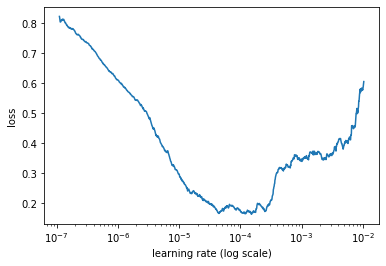

In [35]:
learner.lr_plot()

In [ ]:
learner.autofit(2e-5, 5)



begin training using triangular learning rate policy with max lr of 2e-05...
Train on 24117 samples, validate on 2680 samples
Epoch 1/5


In [ ]:
predictor = ktrain.get_predictor(learner.model, preproc)

In [ ]:
test = pd.read_csv("test.csv")

In [ ]:
prediction = predictor.predict(list(test['comment_text']))

In [ ]:
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
sample_submission = pd.read_csv("sample_submission.csv")

In [ ]:
roc_auc_score(y_test, learner.model.predict(x_test))

In [ ]:
_pred = np.copy(prediction)

In [ ]:
_pred = _pred.T[1].T

In [ ]:
sample_submission[list_classes] = _pred

In [ ]:
sample_submission.to_csv('submission.csv', index=False)

In [1]:
from PIL import Image

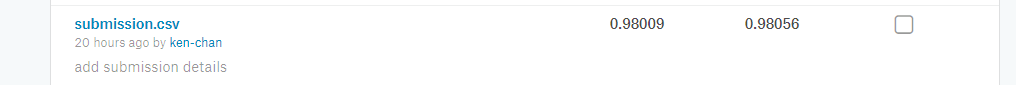

In [2]:
im = Image.open("score.png")
im

______
_Правила полученения дополнительных баллов:_
- можно получить от 20% до 50% в зависимости от метрики качества других участников нашего курса полученного на лидерборде
- Чтобы получить минимум в 20% нужно: 
    - Основные задания должны быть полностью решены
    - Обосновать то решение которое отправили.
    - Предложенная модель должна отличаться от тех, что строились в заданиях 2-4
    
__ Готовый ноутбук загрузите в эту форму: [http://bit.ly/dafe_hw](http://bit.ly/dafe_hw) __

